<h1>Logistic Regression<h1>
<h3>Load in data and import modules<h3>

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('full_mag_insulators.csv')

In [3]:
# Drop rows with missing values in features or target
df = df.dropna(subset=['ordering'])

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

<h3>Exploring Data<h3>
<h4>Removing target column, then determining cardinality for non-numeric columns. As you can see many columns have high cardinality.<h4>

In [81]:
X = df.drop(columns=['ordering'])
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
cardinality = {col: X[col].nunique() for col in non_numeric_cols}
sorted_cardinality = sorted(cardinality.items(), key=lambda x: x[1], reverse=True)

for col, count in sorted_cardinality:
    print(f"{col}: {count} unique values")



material_id: 154801 unique values
structure: 154799 unique values
composition: 117637 unique values
formula: 104794 unique values
elements: 49472 unique values
chemsys: 49472 unique values
symmetry: 519 unique values
is_gap_direct: 2 unique values
is_stable: 2 unique values


<h4>Determining the frequency of certain values for categorical data. Columns with cardinality too high are likely to act as unique identifiers and cause data leakage. Choosing columns with a large variance in frequency of unique values. <h4>

In [68]:
for col in non_numeric_cols:
    print(f"\nColumn: {col}")
    print(X[col].value_counts())


Column: material_id
material_id
mp-6569       2
mp-851255     2
mp-1102830    1
mp-4175       1
mp-2525045    1
             ..
mp-1183152    1
mp-567334     1
mp-1247866    1
mp-554873     1
mp-11107      1
Name: count, Length: 154801, dtype: int64

Column: formula
formula
Li9Mn2Co5O16     729
SiO2             321
Li7Mn2(CoO4)3    230
Li4MnCo2O7       207
CeSe2            175
                ... 
ZnIn3AsSe4         1
ZnMo3O7            1
ZnP2W2O9           1
ZnP4               1
ZrTl2S3            1
Name: count, Length: 104794, dtype: int64

Column: elements
elements
[Element Co, Element Li, Element Mn, Element O]               1684
[Element Mg, Element Si]                                       685
[Element Li, Element O, Element P, Element V]                  671
[Element F, Element Fe, Element O]                             536
[Element Li, Element Mn, Element O]                            481
                                                              ... 
[Element Cr, Element C

<h3>Creating Model<h3>
<h4>Selecting features that are numeric, and have low cardinality or high variance in frequency. Then test-train split data. Use one hot encoding for low cardinality and frequency encoding for high variance in frequency. Then use 4 fold validation.<h4>

In [6]:
# Separate features and target
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
extra_cols = ['is_gap_direct', 'is_stable']
#['symmetry', 'elements', 'chemsys', 'formula', 'composition', 'structure']
categorical_cols = ['symmetry', 'elements', 'chemsys']

# Prepare X and y
X = df[numerical_columns + extra_cols + categorical_cols]
y = df['ordering']

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Frequency encode high-cardinality categorical columns
for col in categorical_cols:
    freq = X_train[col].value_counts()
    X_train[col + '_freq'] = X_train[col].map(freq)
    X_test[col + '_freq'] = X_test[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# One-hot encode the last two columns
X_train = pd.get_dummies(X_train, columns=extra_cols)
X_test = pd.get_dummies(X_test, columns=extra_cols)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42))
])

scores = cross_val_score(pipe, X_train, y_train, cv=4, scoring='accuracy')
print(f"Cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\s

Cross-validated accuracy scores: [0.48493266 0.4913924  0.48488372 0.4870155 ]
Mean accuracy: 0.487


<h4>Checking columns in training set are as desired (removal of high caridnality columns replace with frequency columns).<h4>

In [96]:
print(X_train.columns)
for col in X_train.columns:
    print(col, X_train[col].nunique())

Index(['band_gap', 'numberofelements', 'density_atomic', 'volume', 'nsites',
       'density', 'efermi', 'cbm', 'vbm', 'formation_energy_per_atom',
       'energy_above_hull', 'symmetry_freq', 'is_gap_direct_False',
       'is_gap_direct_True', 'is_stable_False', 'is_stable_True'],
      dtype='object')
band_gap 43478
numberofelements 8
density_atomic 123680
volume 123684
nsites 233
density 123681
efermi 123809
cbm 47481
vbm 48369
formation_energy_per_atom 123765
energy_above_hull 96633
symmetry_freq 179
is_gap_direct_False 2
is_gap_direct_True 2
is_stable_False 2
is_stable_True 2


<h3>Testing<h3>
<h4>Test on testing data set, then create confusion matrix. Sort feature importance by coefficent.<h4>

In [7]:
# Fit on full training set and evaluate on test set
pipe.fit(X_train, y_train)
test_accuracy = pipe.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test set accuracy: 0.491


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

         AFM       0.07      0.58      0.13       683
          FM       0.64      0.29      0.40     11338
         FiM       0.16      0.56      0.25      2269
          NM       0.82      0.61      0.70     16671

    accuracy                           0.49     30961
   macro avg       0.43      0.51      0.37     30961
weighted avg       0.69      0.49      0.55     30961



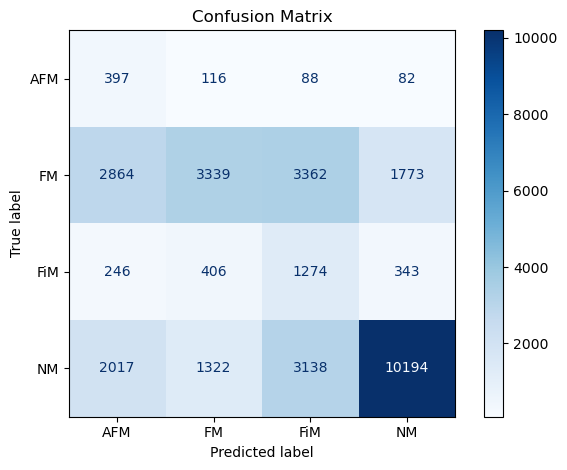

In [9]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = pipe.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=pipe.named_steps['clf'].classes_))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.named_steps['clf'].classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['clf'].classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


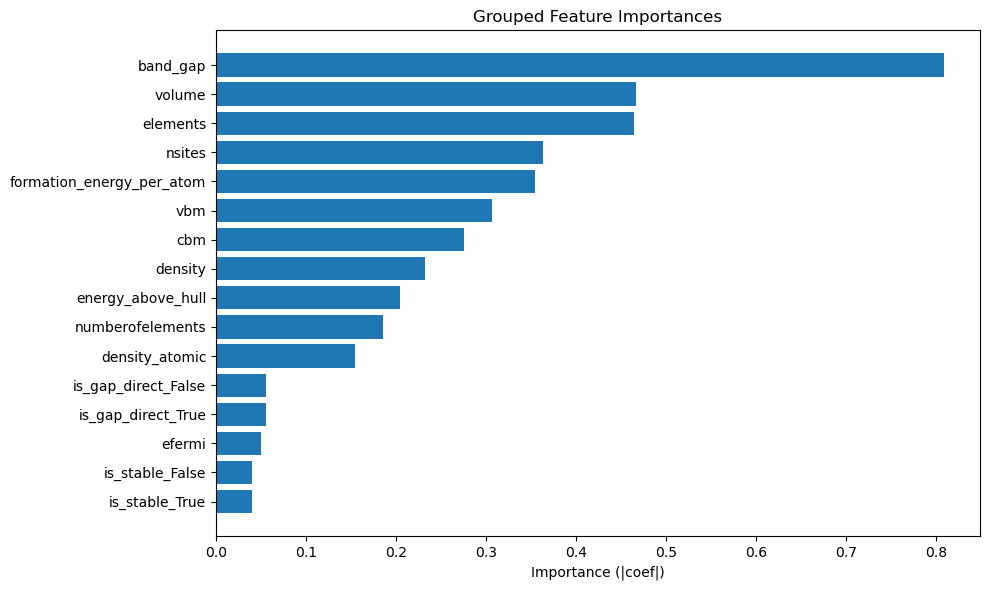

In [10]:
pipe.fit(X_train, y_train)

# For multinomial, take mean absolute value across classes
coefs = np.abs(pipe.named_steps['clf'].coef_).mean(axis=0)
feat_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": coefs
})

numerical_features = numerical_columns
# Add one-hot encoded columns for is_stable and is_gap_direct
onehot_cols = [col for col in X_train.columns if col.startswith('is_stable') or col.startswith('is_gap_direct')]
numerical_features += onehot_cols
numerical_df = feat_df[feat_df["feature"].isin(numerical_features)]
element_importance = feat_df[~feat_df["feature"].isin(numerical_features)]["importance"].sum()

grouped_df = pd.concat([
    numerical_df,
    pd.DataFrame([{"feature": "elements", "importance": element_importance}])
], ignore_index=True)

grouped_df = grouped_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df["feature"], grouped_df["importance"])
plt.xlabel("Importance (|coef|)")
plt.title("Grouped Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [35]:
AFM_count = np.sum(y_test == 'AFM')
print(AFM_count)

683


<h4> Same analysis, but on a filtered set of data, resulting in a marginally reduced accuracy.<h4>

In [40]:
df2 = pd.read_csv('Materials_With_AtLeast_OneMagneticElement.csv')

In [43]:
# Separate features and target
numerical_columns = df2.select_dtypes(include=[np.number]).columns.tolist()
#categorical columns with low cardinality
extra_cols = ['is_gap_direct', 'is_stable']
selected_cols = numerical_columns + [col for col in extra_cols if col in df2.columns]
X2 = df2[selected_cols]
y2 = df2['ordering']


# Convert categorical features to numeric using one-hot encoding
X2_encoded = pd.get_dummies(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2_encoded, y2, test_size=0.2, random_state=42, stratify=y2)

imputer = SimpleImputer(strategy='mean')
X2_train_imputed = imputer.fit_transform(X2_train)
X2_test_imputed = imputer.transform(X2_test)

# Standardize features
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train_imputed)
X2_test_scaled = scaler.transform(X2_test_imputed)


# Logistic regression with 4-fold cross-validation
clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
scores = cross_val_score(clf, X2_train_scaled, y2_train, cv=4, scoring='accuracy')

print(f"Cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\s

Cross-validated accuracy scores: [0.4105052  0.41013201 0.41612241 0.40884493]
Mean accuracy: 0.411


In [45]:
# Fit on full training set and evaluate on test set
clf2.fit(X2_train_scaled, y2_train)
test_accuracy = clf.score(X2_test_scaled, y2_test)
print(f"Test set accuracy: {test_accuracy:.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test set accuracy: 0.405


Classification Report:
              precision    recall  f1-score   support

         AFM       0.08      0.62      0.14       672
          FM       0.66      0.26      0.37     10212
         FiM       0.20      0.54      0.29      2180
          NM       0.70      0.53      0.60      8373

    accuracy                           0.41     21437
   macro avg       0.41      0.49      0.35     21437
weighted avg       0.61      0.41      0.45     21437



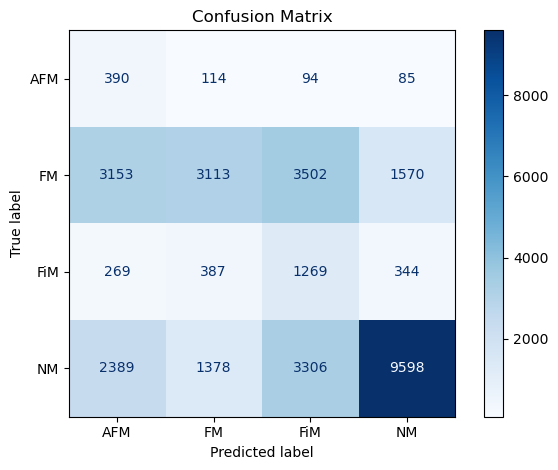

In [46]:
# Predict on the test set
y2_pred = clf2.predict(X2_test_scaled)
print("Classification Report:")
print(classification_report(y2_test, y2_pred, target_names=clf2.classes_))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()